# Setting up our imports and globals

In [1]:
import os
import grp
import math
import anndata
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# These next parts are for removing some noise from the output so as to not confuse the information.
sc.settings.verbosity = 0
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=anndata.ImplicitModificationWarning)

# Setting file paths as variables

In [27]:
user_name = os.environ.get('USER')
class_directory = next(Path('/courses').glob('BINF6430.*'))

# Dynamically identify if the user is a student or instructor
user_group = 'staff' if user_name in grp.getgrnam(f'{class_directory.parts[-1]}-staff').gr_mem else 'students'

student_directory = class_directory / user_group / user_name

# Save output files in student_directory/Project10_Results/
output_dir = student_directory / "Project10"

# Define input data directory
data = class_directory / 'data' / 'LiawData' / '10x_FRP_12-16-22' / 'analysis' / 'MMC-1' / 'outs' / 'per_sample_outs'

# Define the paths for each sample by appending the relative folder structure
sample1_path = data / "49-AdipoB" / "count" / "sample_filtered_feature_bc_matrix"
sample2_path = data / "49-DM"     / "count" / "sample_filtered_feature_bc_matrix"
sample3_path = data / "916-AdipoB" / "count" / "sample_filtered_feature_bc_matrix"
sample4_path = data / "916-DM"     / "count" / "sample_filtered_feature_bc_matrix"

# Loading in the data

In [3]:
# Read each sample using scanpy's read_10x_mtx function
data_s1 = sc.read_10x_mtx(sample1_path, make_unique=True, cache=True)
data_s1.obs['sample'] = "49-AdipoB"

data_s2 = sc.read_10x_mtx(sample2_path, make_unique=True, cache=True)
data_s2.obs['sample'] = "49-DM"

data_s3 = sc.read_10x_mtx(sample3_path, make_unique=True, cache=True)
data_s3.obs['sample'] = "916-AdipoB"

data_s4 = sc.read_10x_mtx(sample4_path, make_unique=True, cache=True)
data_s4.obs['sample'] = "916-DM"

# Concatenate the four samples into one AnnData object.
# batch_key creates a new column 'sample' in adata.obs indicating the source sample.
adata = data_s1.concatenate(data_s2, data_s3, data_s4,
                            batch_key="sample",
                            batch_categories=["49-AdipoB", "49-DM", "916-AdipoB", "916-DM"])

# Identifying genes with the highest fraction of counts in each single cell, across all cells

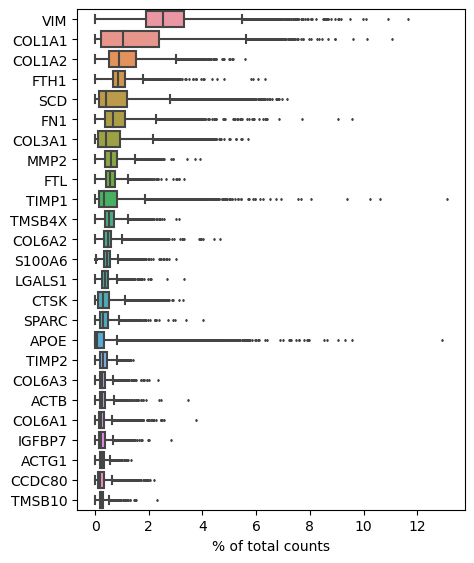

In [4]:
# Ensure gene names are unique to avoid downstream issues
adata.var_names_make_unique()

# Plot the top 25 genes with the highest fraction of counts across cells
sc.pl.highest_expr_genes(adata, n_top=25)

# Capturing QC contol genes

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))
adata.var[adata.var.mt == True]

,gene_ids,feature_types,mt,ribo
MT-ND1,ENSG00000198888,Gene Expression,True,False
MT-ND2,ENSG00000198763,Gene Expression,True,False
MT-CO2,ENSG00000198712,Gene Expression,True,False
MT-ATP6,ENSG00000198899,Gene Expression,True,False
MT-CO3,ENSG00000198938,Gene Expression,True,False
MT-ND3,ENSG00000198840,Gene Expression,True,False
MT-ND4L,ENSG00000212907,Gene Expression,True,False
MT-ND4,ENSG00000198886,Gene Expression,True,False
MT-ND5,ENSG00000198786,Gene Expression,True,False
MT-ND6,ENSG00000198695,Gene Expression,True,False


# Calculating QC metrics

In [6]:
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt','ribo'],
    percent_top=None,
    log1p=False,
    inplace=True,
)

### Data Normalization

In [7]:
adata.obs.pct_counts_mt = adata.obs.pct_counts_mt/100
adata.obs.pct_counts_ribo = adata.obs.pct_counts_ribo/100

### Violin Plots

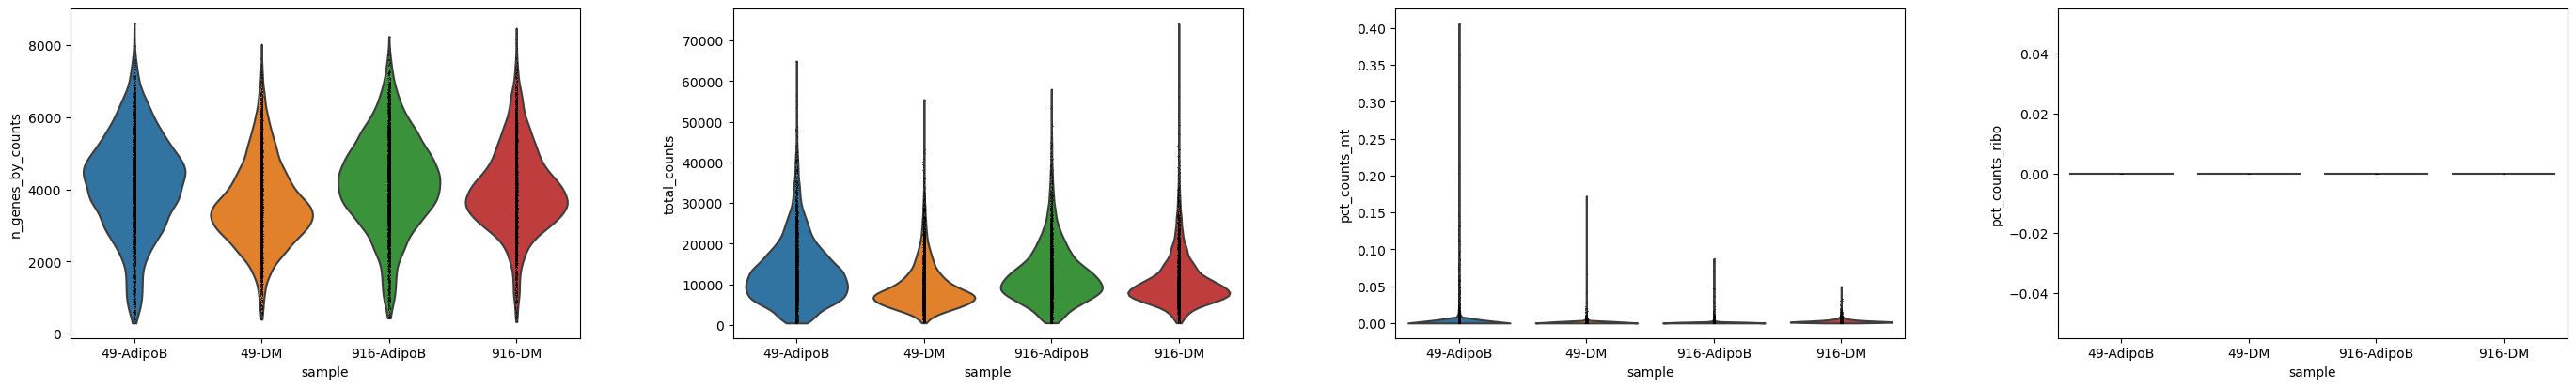

In [8]:
sc.pl.violin(
    adata,
    [
        'n_genes_by_counts',
        'total_counts',
        'pct_counts_mt',
        'pct_counts_ribo'
    ],
    jitter=0.01,
    size=0.5,
    multi_panel=True,
    groupby='sample'
)

### Scatter Plots

# Scatter plots to further explore relationships between metrics
# Here, using color to distinguish the samples
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="sample", show=False, size=10)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="sample", show=False, size=10)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_ribo", color="sample", show=False, size=10)
plt.show()

# Thresholding

## High-level view of the data

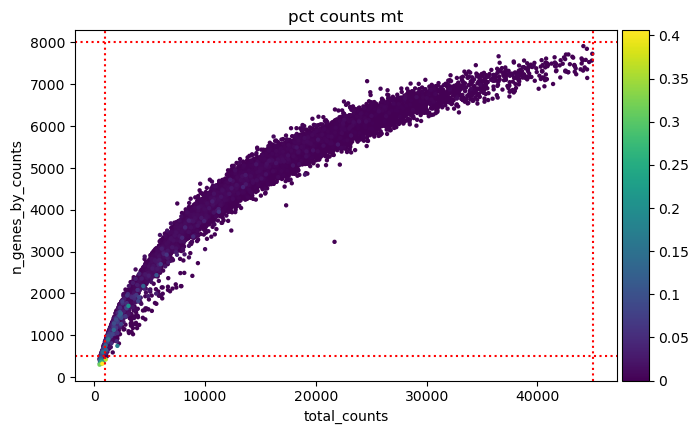

In [9]:
p1 = sc.pl.scatter(
    adata[adata.obs.total_counts<45000],
    'total_counts', 
    "n_genes_by_counts", 
    color="pct_counts_mt", 
    size=40, show=False
)

# Horizontal lines for min/max genes
p1.axhline(500, color='red', linestyle=':')
p1.axhline(8000, color='red', linestyle=':')

# Vertical lines for min/max total counts
p1.axvline(1000, color='red', linestyle=':')
p1.axvline(45000, color='red', linestyle=':')

plt.show()

## Number of UMIs (or cells)

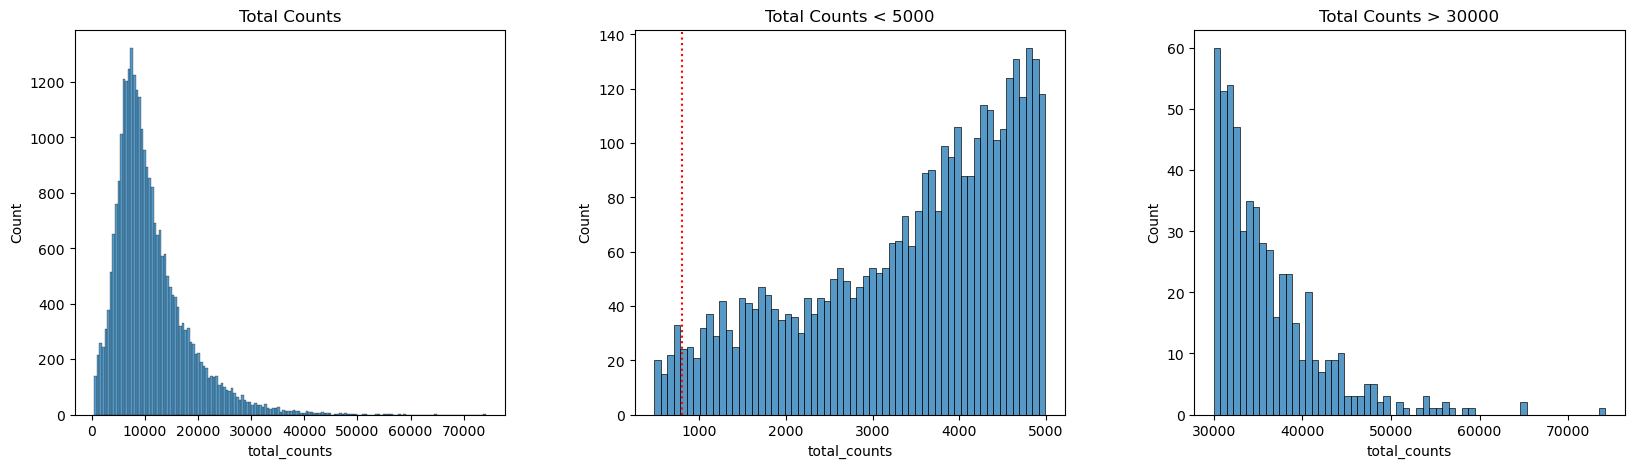

In [10]:
# Set figure size
mpl.rcParams['figure.figsize'] = (20, 5)

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1,3)

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Distribution of total_counts
sns.histplot(adata.obs['total_counts'], kde=False, ax=axes[0])
axes[0].set_title("Total Counts")

# Distribution of total_counts < 5000, vertical line at 825
sns.histplot(adata.obs['total_counts'][adata.obs['total_counts'] < 5000], 
             kde=False, bins=60, ax=axes[1])
axes[1].axvline(800, color='red', linestyle=':')
axes[1].set_title("Total Counts < 5000")

# Distribution of total_counts > 30000
sns.histplot(adata.obs['total_counts'][adata.obs['total_counts'] > 30000], 
             kde=False, bins=60, ax=axes[2])
axes[2].set_title("Total Counts > 30000")

fig.show()
plt.rcdefaults()

### Kernel Density Estimate (KDE) Plot

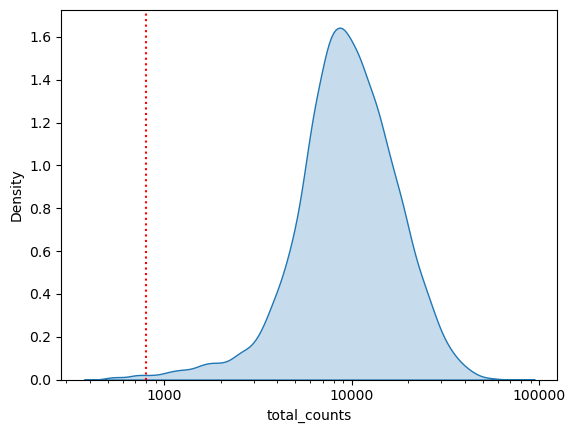

In [11]:
density = sns.kdeplot(adata.obs['total_counts'], shade=True, log_scale=True)
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(800, color='red', linestyle=':')
plt.show()

## Number of genes

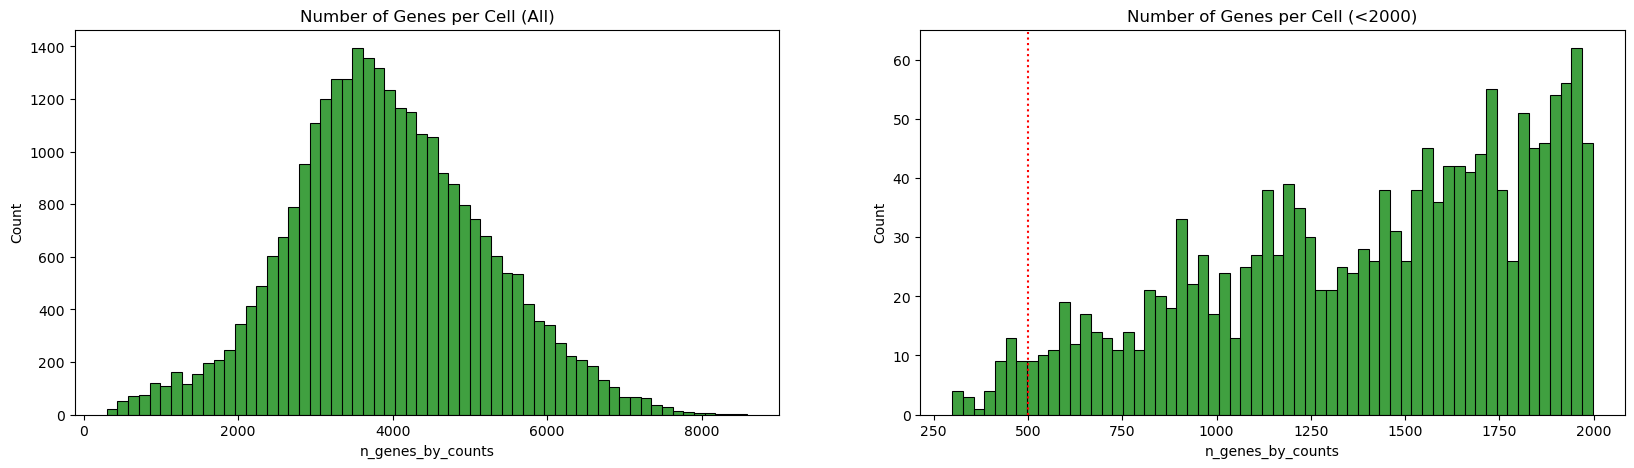

In [12]:
mpl.rcParams['figure.figsize']=(20,5)
fig, axes = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.4, wspace=0.2)

# Histogram of all cells
sns.histplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax=axes[0], color='green')
axes[0].set_title("Number of Genes per Cell (All)")

# Histogram zoomed in on cells with fewer than 1000 genes
sns.histplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts'] < 2000], 
             kde=False, bins=60, ax=axes[1], color='green')
axes[1].axvline(500, color='red', linestyle=':')
axes[1].set_title("Number of Genes per Cell (<2000)")

plt.show()
plt.rcdefaults()

### Kernel Density Estimate (KDE) Plot

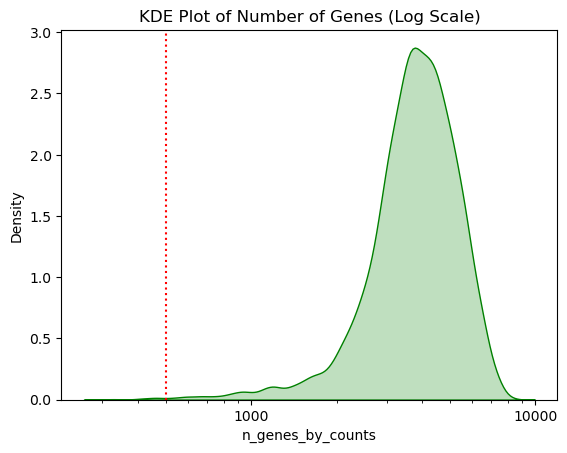

In [13]:
# KDE plot of n_genes_by_counts on a log scale
density = sns.kdeplot(adata.obs['n_genes_by_counts'], shade=True, log_scale=True, color='green')
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(500, color='red', linestyle=':')
plt.title("KDE Plot of Number of Genes (Log Scale)")
plt.show()

## Mitochondiral and ribosomal gene ratio

### Mitochrondrial gene ratio

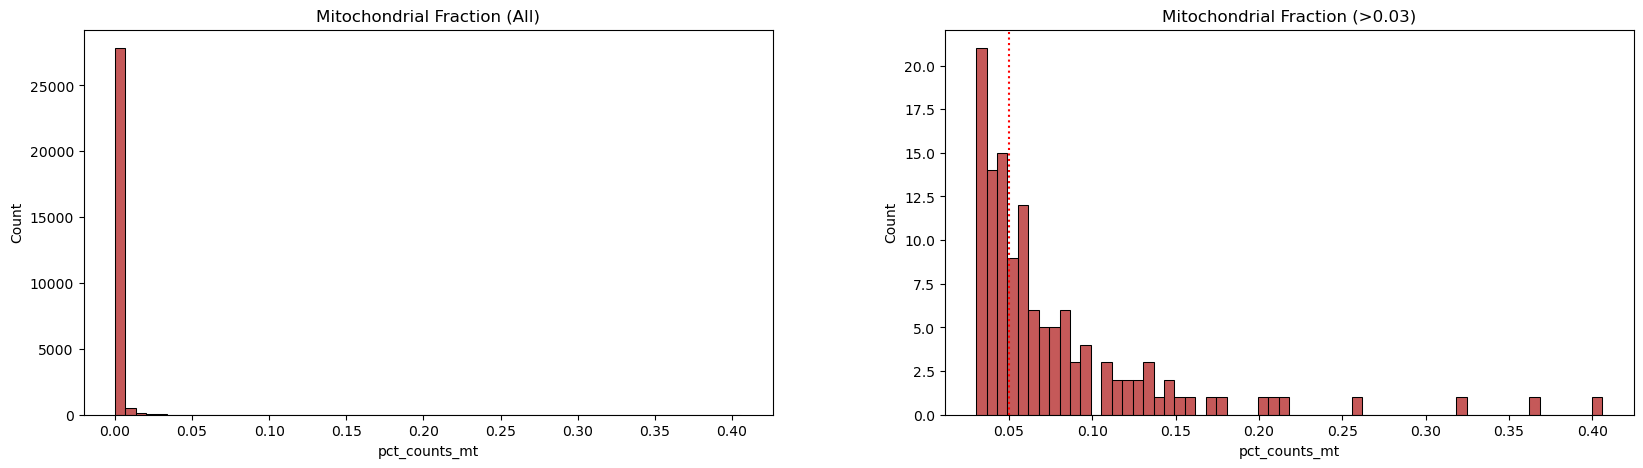

In [14]:
mpl.rcParams['figure.figsize']=(20,5)
fig, axes = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.4, wspace=0.25)

# All mitochondrial fractions
sns.histplot(adata.obs['pct_counts_mt'], kde=False, bins=60, ax=axes[0], color='firebrick')
axes[0].set_title("Mitochondrial Fraction (All)")

# Focus on cells with mt fraction > 0.03
sns.histplot(adata.obs['pct_counts_mt'][adata.obs['pct_counts_mt'] > 0.03], 
             kde=False, bins=60, ax=axes[1], color='firebrick')
axes[1].axvline(0.05, color='red', linestyle=':')
axes[1].set_title("Mitochondrial Fraction (>0.03)")

plt.show()
plt.rcdefaults()

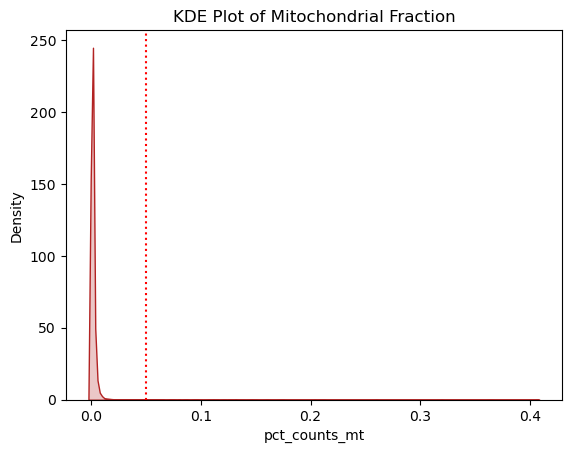

In [15]:
# KDE plot for mt fraction
density = sns.kdeplot(adata.obs['pct_counts_mt'], shade=True, color='firebrick')
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(0.05, color='red', linestyle=':')
plt.title("KDE Plot of Mitochondrial Fraction")
plt.show()

### Ribosomal gene ratio

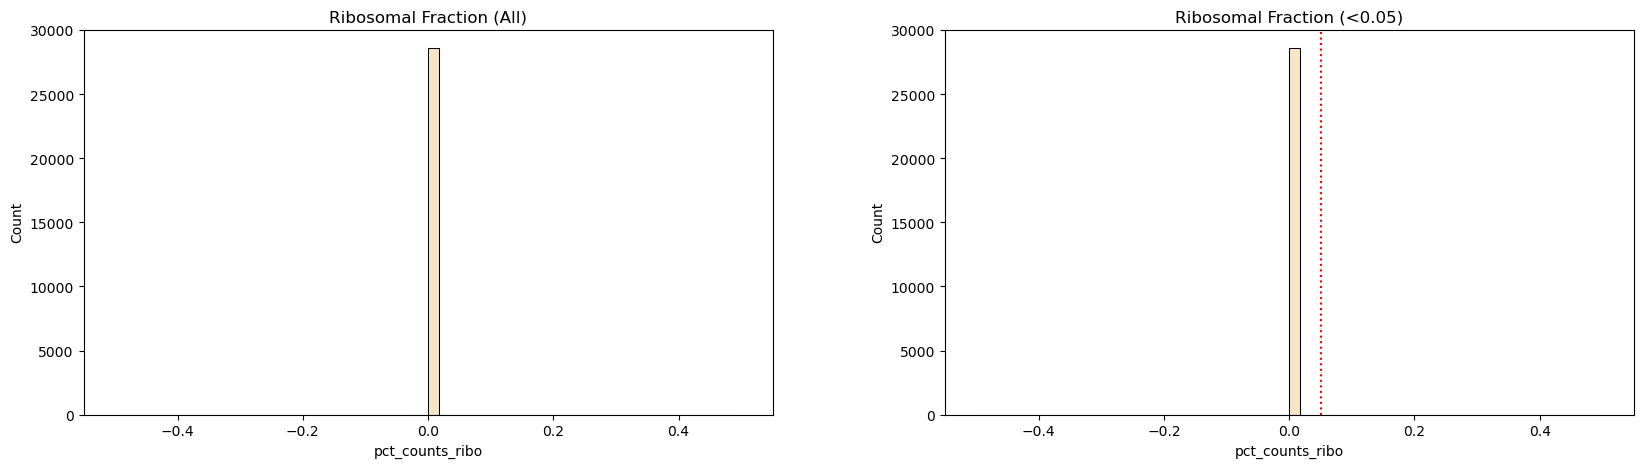

In [16]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.25)

# All ribosomal fractions
sns.histplot(adata.obs['pct_counts_ribo'], kde=False, bins=60, ax=axes[0], color='wheat')
axes[0].set_title("Ribosomal Fraction (All)")

# Focus on cells with ribosomal fraction < 0.05
sns.histplot(adata.obs['pct_counts_ribo'][adata.obs['pct_counts_ribo'] < 0.05], 
             kde=False, bins=60, ax=axes[1], color='wheat')
axes[1].axvline(0.05, color='red', linestyle=':')
axes[1].set_title("Ribosomal Fraction (<0.05)")

plt.show()
plt.rcdefaults()

/home/bhowmick.a/.conda/envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  


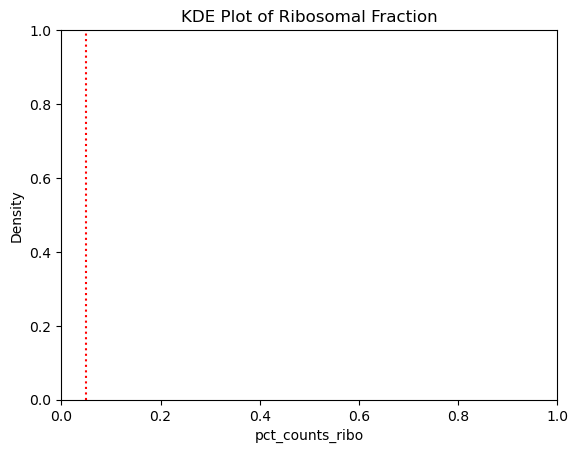

In [17]:
# KDE plot for ribosomal fraction
density = sns.kdeplot(adata.obs['pct_counts_ribo'], shade=True, color='wheat')
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(0.05, color='red', linestyle=':')
plt.title("KDE Plot of Ribosomal Fraction")
plt.show()

## Cells per gene

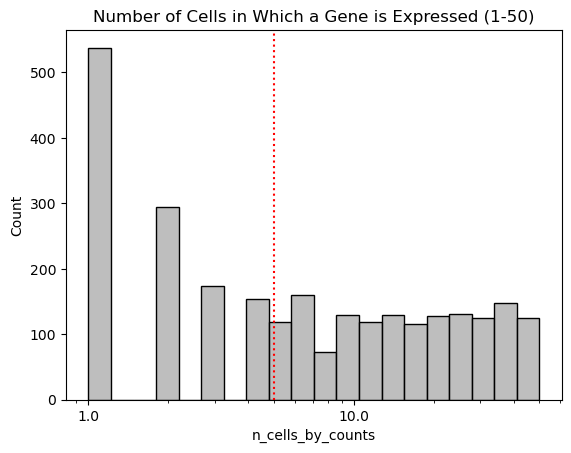

In [18]:
# Histogram of how many cells each gene is expressed in, focusing on genes detected in 1–50 cells
gbc = sns.histplot(
    adata.var['n_cells_by_counts'][adata.var['n_cells_by_counts'].between(1, 50)],
    color='darkgrey',
    bins=20,
    log_scale=True
)
gbc.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(5, color='red', linestyle=':')
plt.title("Number of Cells in Which a Gene is Expressed (1-50)")
plt.show()

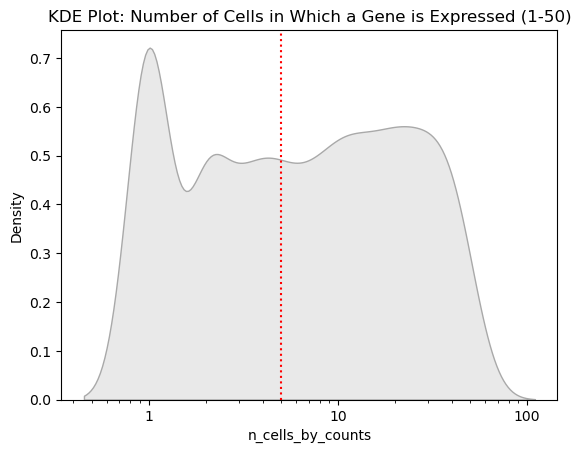

In [19]:
# KDE plot for the same range
gbc2 = sns.kdeplot(
    adata.var['n_cells_by_counts'][adata.var['n_cells_by_counts'].between(1, 50)],
    color='darkgrey',
    shade=True,
    log_scale=True
)
gbc2.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(5, color='red', linestyle=':')
plt.title("KDE Plot: Number of Cells in Which a Gene is Expressed (1-50)")
plt.show()

## Summary of thresholding
<details>
    <summary>Click to see final thresholds</summary>
Our thresholds for this data are as follows:
    
1. Minimum total counts: 1000
2. Minimum genes: 500
3. Maximum Mitochondrial fraction: 5%
4. Cells per gene: 3
</details></br>

# Filtering

In [20]:
# Selected thresholds
min_counts = 1000
min_genes = 500
max_mt_ratio = 0.05
min_cells = 3

In [21]:
# Sanity check using the Seurat recipe
seurat_adata = sc.pp.recipe_seurat(adata, copy=True)
print(f'Number of cells after filtering (recipe_seurat): {seurat_adata.n_obs:d}.')
print(f'Number of genes after filtering (recipe_seurat): {seurat_adata.n_vars:d}\n')

Number of cells after filtering (recipe_seurat): 28618.
Number of genes after filtering (recipe_seurat): 406



## Serial filtering

In [22]:
# Helper function to print cell counts per sample
def print_sample_counts(adata_obj, stage=""):
    counts = adata_obj.obs['sample'].value_counts()
    print(f"Cell counts {stage}: {adata_obj.n_obs} total cells")
    print(counts, "\n")

# Print counts before filtering
print_sample_counts(adata, "before filtering")

# Serial filtering

# Filter cells with total counts below the threshold
sc.pp.filter_cells(adata, min_counts=min_counts)
print_sample_counts(adata, "after min_counts filtering")

# Filter cells with high mitochondrial fraction
adata = adata[adata.obs.pct_counts_mt < max_mt_ratio]
print_sample_counts(adata, "after mitochondrial (mt) filter")

# Filter cells with few detected genes
sc.pp.filter_cells(adata, min_genes=min_genes)
print_sample_counts(adata, "after gene filter")

# Check the gene count before gene filtering
print(f"Total number of genes before gene filter: {adata.n_vars:d}")

# Filter genes expressed in fewer than min_cells cells
sc.pp.filter_genes(adata, min_cells=min_cells)
print(f"Number of genes after cell filter: {adata.n_vars:d}")

Cell counts before filtering: 28618 total cells
49-DM         9602
916-DM        6979
916-AdipoB    6094
49-AdipoB     5943
Name: sample, dtype: int64 

Cell counts after min_counts filtering: 28458 total cells
49-DM         9566
916-DM        6957
916-AdipoB    6059
49-AdipoB     5876
Name: sample, dtype: int64 

Cell counts after mitochondrial (mt) filter: 28406 total cells
49-DM         9565
916-DM        6957
916-AdipoB    6058
49-AdipoB     5826
Name: sample, dtype: int64 

Cell counts after gene filter: 28405 total cells
49-DM         9565
916-DM        6956
916-AdipoB    6058
49-AdipoB     5826
Name: sample, dtype: int64 

Total number of genes before gene filter: 18082
Number of genes after cell filter: 15034


## Data Normalization

In [23]:
adata = sc.pp.normalize_total(adata, target_sum=1e4, copy = True)
sc.pp.log1p(adata)

## Removing highly variable genes

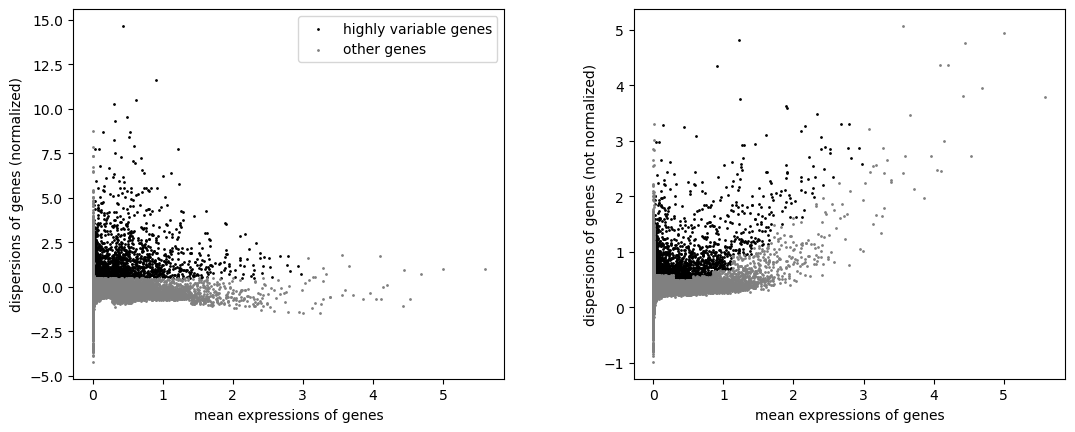

In [24]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

# Doublet Removal

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sc.external.pp.scrublet(adata)
    adata = adata[~adata.obs.predicted_doublet]
    print(f'{adata.obs.predicted_doublet.sum()} doublets detected and removed.')

Automatically set threshold at doublet score = 0.14
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 79.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.8%
0 doublets detected and removed.


# Saving our `adata` objects

In [28]:
# Get unique sample names from the concatenated AnnData object
samples = adata.obs['sample'].unique()

# Loop over each sample and save its subset to a separate file
for sample in samples:
    # Subset and copy the data for this sample
    adata_sample = adata[adata.obs['sample'] == sample].copy()
    # Define the output file path
    output_file = output_dir / f"{sample}_filtered.h5ad"
    # Save the AnnData object to file
    adata_sample.write_h5ad(output_file)
    print(f"Saved sample {sample} with {adata_sample.n_obs} cells and {adata_sample.n_vars} genes to {output_file}")

Saved sample 49-AdipoB with 5730 cells and 15034 genes to /courses/BINF6430.202530/students/bhowmick.a/Project10/49-AdipoB_filtered.h5ad
Saved sample 49-DM with 9324 cells and 15034 genes to /courses/BINF6430.202530/students/bhowmick.a/Project10/49-DM_filtered.h5ad
Saved sample 916-AdipoB with 5959 cells and 15034 genes to /courses/BINF6430.202530/students/bhowmick.a/Project10/916-AdipoB_filtered.h5ad
Saved sample 916-DM with 6772 cells and 15034 genes to /courses/BINF6430.202530/students/bhowmick.a/Project10/916-DM_filtered.h5ad
